# Facial recognition convolutional neural network, multi class and multi label

In [1]:
!pip install tensorflow==2.1.0

In [2]:
!git clone https://github.com/Mike-In-The-Cloud/comp1804.git

fatal: destination path 'comp1804' already exists and is not an empty directory.


In [73]:
import numpy as np #  provides a multidimensional array object
import matplotlib.pyplot as plt # library for visualizations, graphs
import matplotlib.image as mping # used to read image paths
import tensorflow as tf # machine learning framework
import matplotlib.pyplot as plt # graph plotting library
import pandas as pd # data manipluation
import cv2 # computer vision library
from sklearn.metrics import confusion_matrix # plotting tool for confususion matrix
import skimage.io as io # read write images in various formats
import itertools # Functions creating iterators for efficient looping
import random # used to generate random numbers
from PIL import Image # python image libary
import os # OS manipuilation 
from matplotlib import pyplot
from sklearn.model_selection import train_test_split # used to split the dataset into training and testing data
# importing modules from tensorflow.keras to keep code readable
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, BatchNormalization, MaxPooling2D, Activation,MaxPool2D,GlobalMaxPool2D,MaxPooling3D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,RMSprop, Adagrad
from imgaug import augmenters as iaa # image augmentation library
%matplotlib inline

import ntpath

In [4]:
print("Tensorflow version:",tf.__version__) # check tensorflow version is tensorflow 2.1 or the class weights will not work

Tensorflow version: 2.1.0


### Variables

In [5]:
root = "comp1804" # parent folder to save all data
image_data = 'dataset/'
video_data = 'video'

In [6]:
dataset_dict = {
    'wrinkles_id':{
        0: 'does not have',
        1: 'has'
    },
    'freckles_id' :{
        0: 'does not have',
        1: 'has'
    },
    'glasses_id' :{
        0: 'does not have',
        1: 'wear normal',
        2: 'wear sunglasses'
    },
    'hair_colour_id' :{
        0: 'brown',
        1: 'black',
        2: 'grey',
        3: 'blonde',
        4: 'red',
        5: 'white',
        6: 'mixed',
        7: 'other',
        8: 'not visible'
    },
    'hair_top_id':{
        0: 'bald or shaved',
        1: 'has few hair',
        2: 'has thick hair',
        3: 'not visible'
    },
    'human_id':{
        0: 'human',
        1: 'Not Human'
    }
}

### Hyperperameters

In [117]:
MODEL_NAME = "model_24" # name of model
BATCH_SIZE = 32 # batch size to pass while training
EPOCS = 10 # number of epochs to run
STEPS = 50
ACTIVATION_LAYER = "relu"  # activation function
ACTIVATION_OUTPUT = "softmax" # output activation function
OPTIMIZER = 'Adagrad' # optimiser

### Directory checking or creation

In [118]:
# Model data files
if not os.path.exists('%s/Model_Data/%s' %(root, MODEL_NAME)):
    os.makedirs('%s/Model_Data/%s' %(root, MODEL_NAME))
    print("***\nNew model directory created\n***")
else:
    print("***\nModel directory already present\n***")
# file for plots
if not os.path.exists('%s/plots'%(root)):
    os.makedirs('%s/plots'%(root))
    print("***\n New plot directory created\n***")
else:
    print("***\nPlot directory already present\n***")


***
New model directory created
***
***
Plot directory already present
***


### Load csv file with file locations and annotations

In [9]:
# reading the csv file that has been generated
data = pd.read_csv(os.path.join(root,'dataset.csv'))#, names = CATEGORIES)  # joins the data together
# displays the output on a single line
pd.set_option('display.max_colwidth', None)
# read the first 5 lines to test the current code is working
data.head()

,image_name,wrinkles,freakles,glasses,hair_color,hair_top,not_human
0,/home/michael/DataSciMSc/comp1804-AppliedML/coursework/data/dataset/unsplash_805.jpg,0,0,0,1,2,0
1,/home/michael/DataSciMSc/comp1804-AppliedML/coursework/data/dataset/unsplash_830.jpg,0,0,1,8,3,0
2,/home/michael/DataSciMSc/comp1804-AppliedML/coursework/data/dataset/unsplash_1060.jpg,0,0,0,4,2,0
3,/home/michael/DataSciMSc/comp1804-AppliedML/coursework/data/dataset/unsplash_1136.jpg,0,0,0,1,2,0
4,/home/michael/DataSciMSc/comp1804-AppliedML/coursework/data/dataset/unsplash_1342.jpg,0,0,0,3,2,0


In [10]:
# function that takes in the path arguement and splits the path
def path_leaf(path):
  head, tail = ntpath.split(path) # splits the path
  return tail # returns the tail end of the split path

# data frame serise type, invoking the function path_leaf
data['image_name'] = data['image_name'].apply(path_leaf) # this takes the entire data frame and returns only the tail end of the path
#outputs the data
print(data.head())
print("Total data lenght:", len(data))

          image_name  wrinkles  freakles  ...  hair_color  hair_top  not_human
0   unsplash_805.jpg         0         0  ...           1         2          0
1   unsplash_830.jpg         0         0  ...           8         3          0
2  unsplash_1060.jpg         0         0  ...           4         2          0
3  unsplash_1136.jpg         0         0  ...           1         2          0
4  unsplash_1342.jpg         0         0  ...           3         2          0

[5 rows x 7 columns]
Total data lenght: 2153


In [11]:
# function takes numpy array and checks unique element count, returns array
def count_freq(numpy_data):
    (unique, counts) = np.unique(numpy_data, return_counts=True)
    frequencies = np.asarray((unique, counts)).T   # hold the frequency of each value
    return frequencies  

In [12]:
# function takes in numpy array and string, output bar graphs showing 
# distribution of training and testing data
def plot_freq(frequency, title, labels,filename=""):
    #labels = frequency[:,0] # labels for x axis
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1]) # axes is absolute coordinates on plot
    
    ax.bar(frequency[0:10, 0],frequency[0:10, 1]) # x and y axis for plot
    plt.xticks(frequency[0:10, 0], labels=labels, rotation = 45) # define the x labels
    plt.title("Distribution of %s"%title) # title
    plt.xlabel(title) # x axis label
    plt.ylabel("Number of images")# y axis label
    # loop to get frequency data and display on chart
    for index,data in enumerate(frequency[0:10, 1]):
        # position the text data 
        plt.text(x=index , y =data+1 , s=f"{data}" , fontdict=dict(fontsize=10),ha="center")
    if not os.path.exists("%s/plots/%s.png"% (root,filename)):
        plt.savefig("%s/plots/%s.png"% (root,filename),bbox_inches='tight')

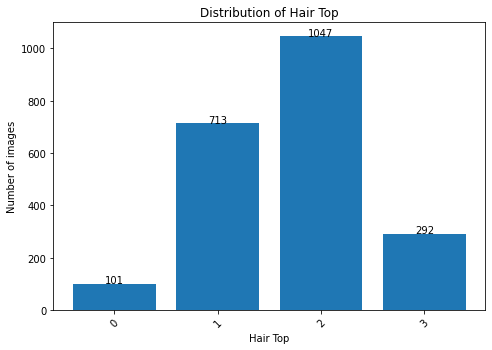

In [13]:
plot_freq(count_freq(data['hair_top']), "Hair Top", dataset_dict['hair_top_id'],"hair_top extra input")

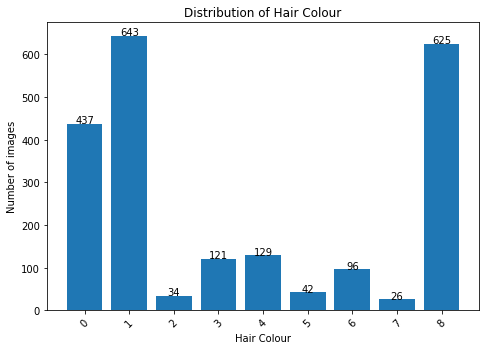

In [14]:
plot_freq(count_freq(data['hair_color']), "Hair Colour", dataset_dict['hair_colour_id'],"Hair_Colour extra input")

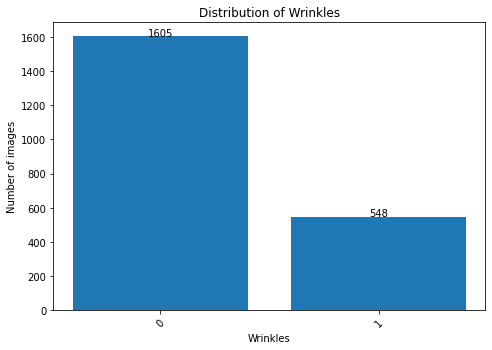

In [15]:
plot_freq(count_freq(data['wrinkles']), "Wrinkles", dataset_dict['wrinkles_id'],'wrinkles extra input')

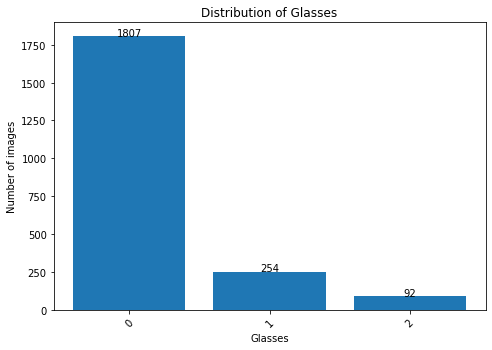

In [16]:
plot_freq(count_freq(data['glasses']), "Glasses", dataset_dict['glasses_id'],"glasses extra input")

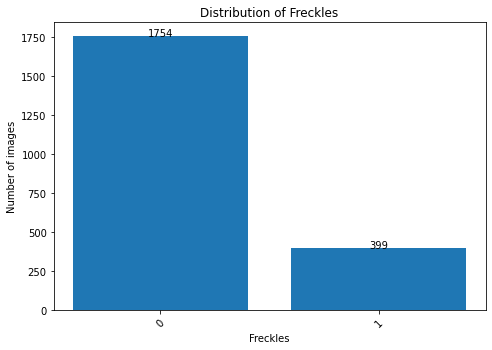

In [17]:
plot_freq(count_freq(data['freakles']), "Freckles", dataset_dict['freckles_id'],"freckles extra input")

### the following cells were used to try and balance the dataset by removing items from the dataframe and setting each class to have a maximum of 129 items in each class

In [18]:
import plotly.graph_objects as go
def plot_distribution(pd_series):
    labels = pd_series.value_counts().index.tolist()
    counts = pd_series.value_counts().values.tolist()
    
    pie_plot = go.Pie(labels=labels, values=counts, hole=.3)
    fig = go.Figure(data=[pie_plot])
    fig.update_layout(title_text='Distribution for %s' % pd_series.name)
    
    fig.show()

In [19]:
plot_distribution(data['not_human'])

In [20]:
mask = data['not_human'] == 1
index_number = np.flatnonzero(mask)
index_number
data.drop(data.index[index_number])
#for i in index_number:
#    data = data.drop([i])
#print("Total data lenght: ",len(data))
data = data.drop(columns=['not_human'])


In [21]:
data.head()

,image_name,wrinkles,freakles,glasses,hair_color,hair_top
0,unsplash_805.jpg,0,0,0,1,2
1,unsplash_830.jpg,0,0,1,8,3
2,unsplash_1060.jpg,0,0,0,4,2
3,unsplash_1136.jpg,0,0,0,1,2
4,unsplash_1342.jpg,0,0,0,3,2


# This block of code would use hair colour and seperate them into 9 bins based on the colour then remove indexes from the dataframe in an attempt to remove bias on hair colour

In [22]:
# visualising the data of hair colour into a histogram 
#num_bins = 9 # odd number picked as there are 9 classes
#samples_per_bin = 129 # sets the maximum number of samples per bin to 129, this stops the bias to one class
#hist, bins = np.histogram(data['hair_color'], num_bins) # accessing all the data divided by 9 bins
#center = (bins[:-1] + bins[1:]) * 0.5 # element wise addition between the 2 segments, this centers the bins around 0
#plt.bar(center, hist, width = 1) # plotting the histogram on a bar graph shows the frequency of hair color
#plt.plot((np.min(data['hair_color']),np.max(data['hair_color'])), (samples_per_bin, samples_per_bin,),color='red') # displays a line where anything under the line will be used 


In [23]:
#print('Total data:', len(data)) # shows the length of the data at the start
#remove_list = [] # empty list for data that will be removed 
# looping throught all the data 
#for j in range(num_bins):
#  list_ = [] # empty list
#  for i in range(len(data['hair_color'])): # loop through the hair colour
#    if data['hair_color'][i] >= bins[j] and data['hair_color'][i] <= bins[j+1]: # isolate the hair colour with the bin currently being itterated through
#      list_.append(i) # appends the data to a list
#  list_ = list_[samples_per_bin:] # isolate the bins that go beyond the threshold of 200
#  remove_list.extend(list_) # speards the contents of the data removed into removed list

#print('Removed:', len(remove_list)) # shows the lenght of the removed data
#data.drop(data.index[remove_list], inplace=True) # drops specfic rows of data that corrisonds to the remove_list, inplace = True is updated value remains on the same copy
#print('Remaining:', len(data)) # shows the length of the data that is remaining 

#hist, _ = np.histogram(data['hair_color'], (num_bins)) # takes all steering data and 
#plt.bar(center, hist, width = 0.8) # plotting the histogram on a bar graph shows the frequency of steering angle
#plt.plot((np.min(data['hair_color']),np.max(data['hair_color'])), (samples_per_bin, samples_per_bin)) # displays a line where anything under the line will be used 

### Clean data of non human images

# Visualise data after cleaning and augmenting

In [24]:
#plot_freq(count_freq(data['hair_top']), "Distribution of Hair Top Augmented", dataset_dict['hair_top_id'],"hair_top augmented")

In [25]:
#plot_freq(count_freq(data['hair_color']), "Distribution of Hair Colour Augmented", dataset_dict['hair_colour_id'],"Hair_Colour augmented")


In [26]:
#plot_freq(count_freq(data['wrinkles']), "Distribution of wrinkles Augmented", dataset_dict['wrinkles_id'],'wrinkles augmented')


In [27]:
#plot_freq(count_freq(data['glasses']), "Distribution of glasses Augmented", dataset_dict['glasses_id'],"glasses augmented")


In [28]:
#plot_freq(count_freq(data['freakles']), "Distribution of freckles Augmented", dataset_dict['freckles_id'],"freckles augmented")

# Image preprocessing

In [29]:
"""
Loads images from disk to numpy array
"""
def load_images(datadir, dataframe):
    image_path = []
    image_annotation = []
    # loops through length of updated data
    for i in range(len(data)): # loop though the lenght of the data
        indexed_data = data.iloc[i]
        image_name = indexed_data[0]
        image_path.append(os.path.join(datadir,image_name.strip()))
        
        image_annotation.append([indexed_data[1],indexed_data[2],indexed_data[3],indexed_data[4],indexed_data[5]])
      
        
        
    image_paths = np.asarray(image_path)
    image_annotations = np.asarray(image_annotation)
    return image_paths, image_annotations


In [30]:
image_paths, image_annotations = load_images(root+"/"+image_data , data)

In [31]:
# splits the dataset into training data and training data
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, image_annotations, test_size = 0.2, random_state = 6) # data is split with 80% training and 20% validaiotn data
print('Training samples: {} \nValidation Samples: {}'.format(len(X_train), len(X_valid)))

Training samples: 1722 
Validation Samples: 431


In [32]:
#function for pre processing
def img_preprocess(img):
  img = cv2.resize(img, (150,150)) # resize the image to reduce the computational power needed
  if (img.shape == (150,150,4)): # changing any rgba images to rgb for uniformity
    img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)
  
  img = img[:, :, :3] # change shape to 3 dimentional array
  img = cv2.GaussianBlur(img, (3,3), 0 ) # smooths image out and reduces the noise of the image
  # above the arguments are the image, the size of the kernal and the deviation of the kernal
  #img = cv2.resize(img, (200,200)) # resize the image to reduce the computational power needed
  # image as first argument tuple as second that the image will be resized too
  img = img/255 # nomalisation of the image
  return img # returns pre processed image

#### Check preprocessing works

Text(0.5, 1.0, 'Preprocessed Image')

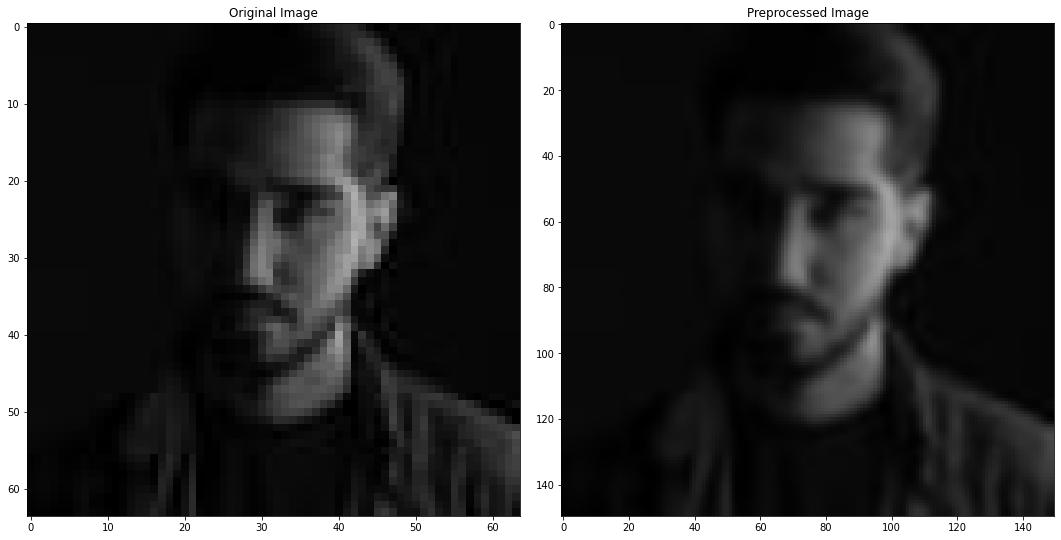

In [33]:


image = image_paths[17] # selects an image that is currently set to index 100
original_image = mping.imread(image) # stores original image that has been read into this variable
preprocessed_image = img_preprocess(original_image) # same image that has been preprocessed using the defined function

fig, axes = plt.subplots(1, 2, figsize=(15,10)) # defines a sub plot to show the original and preprocessed images
fig.tight_layout() # formatting the images
axes[0].imshow(original_image) # show the original image
axes[0].set_title('Original Image') # title of the original image
axes[1].imshow(preprocessed_image) # preprocessed image
axes[1].set_title('Preprocessed Image') # title of the original image

### Batch generator to load images, preprocess and augment on the fly

In [34]:
#function for batch agumentation
def batch_generator(image_paths, annotations, batch_size, istraining): 
  while True:
    batch_img = [] # stores image in list
    batch_annotations = [] # stores the annotation in a list 
    wrinkles,freakles,glasses,hair_colors,hair_tops = [], [],[],[],[]
    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) -1 ) # randomly selects image
      
      # if statement to test between training images and validation images
      if istraining:
        # training data
        person = data.iloc[random_index]
        wrinkle = person["wrinkles"]
        freakle = person["freakles"]
        glass = person["glasses"]
        hair_color = person["hair_color"]
        hair_top = person["hair_top"]
        
        img,annotation= random_augment(image_paths[random_index],annotation = annotations[random_index]) # stores the randomly selected images and annotation in variables
        
        wrinkles.append(to_categorical(wrinkle, len(dataset_dict['wrinkles_id'])))
        freakles.append(to_categorical(freakle, len(dataset_dict['freckles_id'])))
        glasses.append(to_categorical(glass, len(dataset_dict['glasses_id'])))
        hair_colors.append(to_categorical(hair_color, len(dataset_dict['hair_colour_id'])))
        hair_tops.append(to_categorical(hair_top, len(dataset_dict['hair_top_id'])))
        
      else:
        # validaiton data
        img = mping.imread(image_paths[random_index])
        person = data.iloc[random_index]
        wrinkle = person["wrinkles"]
        freakle = person["freakles"]
        glass = person["glasses"]
        hair_color = person["hair_color"]
        hair_top = person["hair_top"]
        annotation = annotations[random_index]
        wrinkles.append(to_categorical(wrinkle, len(dataset_dict['wrinkles_id'])))
        freakles.append(to_categorical(freakle, len(dataset_dict['freckles_id'])))
        glasses.append(to_categorical(glass, len(dataset_dict['glasses_id'])))
        hair_colors.append(to_categorical(hair_color, len(dataset_dict['hair_colour_id'])))
        hair_tops.append(to_categorical(hair_top, len(dataset_dict['hair_top_id'])))
        
      img = img_preprocess(img) # call to function
      batch_img.append(img) # appends the image to list
      batch_annotations.append(annotation) # appends the annotation angle to list
      
    yield (np.asarray(batch_img), [np.array(wrinkles), np.array(freakles), np.array(glasses), np.array(hair_colors), np.array(hair_tops)]) # using yield to suspend the function
    wrinkles,freakles,glasses,hair_colors,hair_tops = [], [],[],[],[]

# Image augmentation

In [35]:
# image augmentation
def zoom(image):
  zoom = iaa.Affine(scale = (1, 1.4)) # zoom function set to between 1x and 1.4x zoom
  image = zoom.augment_image(image) # augments the zoom of image
  return image

Text(0.5, 1.0, 'Zoomed Image')

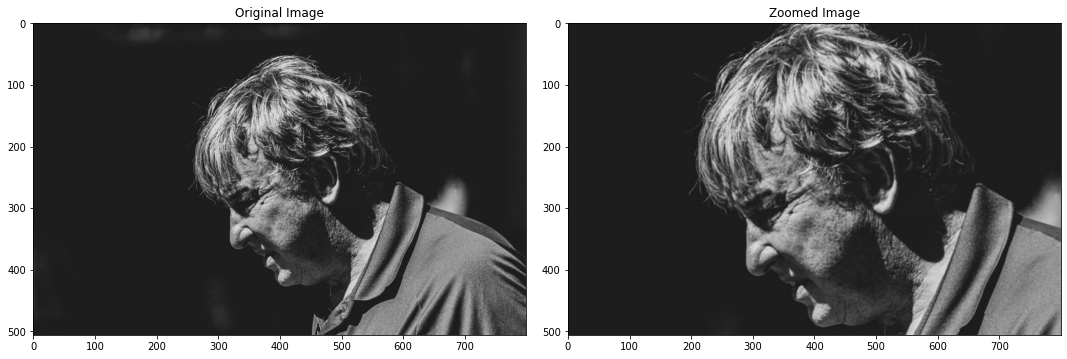

In [36]:
# displaying zoomed image

image = image_paths[random.randint(0,1000)]# randomly selects an image with the index between 0 - 1000
original_image = mping.imread(image) # reads image path
zoomed_image = zoom(original_image) # sends original image to function

fig, axs = plt.subplots(1, 2, figsize=(15,10)) # plot to display the images
fig.tight_layout()  # tidy up the plot
axs[0].imshow(original_image) # original image
axs[0].set_title('Original Image')# title of the original image
axs[1].imshow(zoomed_image) # displays the zoom augmented image
axs[1].set_title('Zoomed Image') # titles the zoom augmented image

In [37]:
# flipping augmentation
def img_random_flip(image): # function takes image and steering angle 
  image = cv2.flip(image, 1) # horizontal flip
  return image # returns the image and steering angle

Text(0.5, 1.0, 'Flipped Image ')

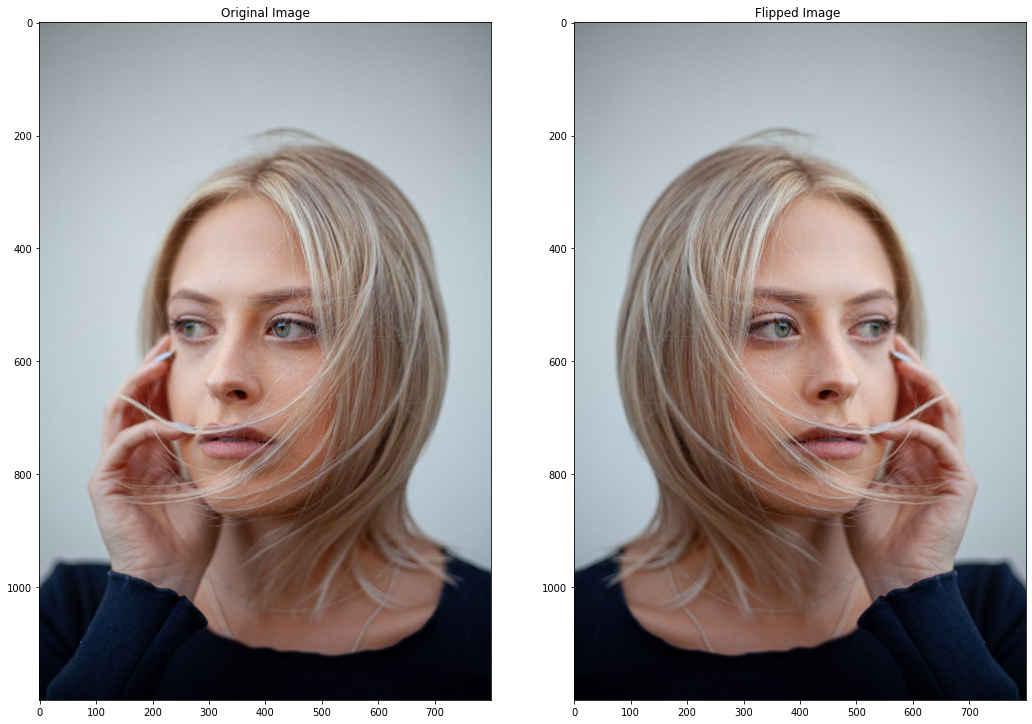

In [38]:
random_index = random.randint(0,1000) # random number between 0 and 1000
image = image_paths[random_index] # displays image at the index of randomly generated number

original_image = mping.imread(image) # original image path being read
flipped_image = img_random_flip(original_image) # flipped image and steering angle

fig, axs = plt.subplots(1, 2, figsize=(15,10))# displays the image and the steering angle
fig.tight_layout() # tidy up the display of images
axs[0].imshow(original_image) # shows the original image
axs[0].set_title('Original Image') # sets title to original image 
axs[1].imshow(flipped_image) # displays the flipped image
axs[1].set_title('Flipped Image ') # sets title for the flipped image 

In [39]:
# image panning
def pan(image):
  pan = iaa.Affine(translate_percent={'x': (-0.1,0.1), 'y':(0.1,0.1)}) # panning 10% left or right and 10% up or down
  image = pan.augment_image(image) # augments the image with pan function
  return image # returns an augmented image

Text(0.5, 1.0, 'Panned Image')

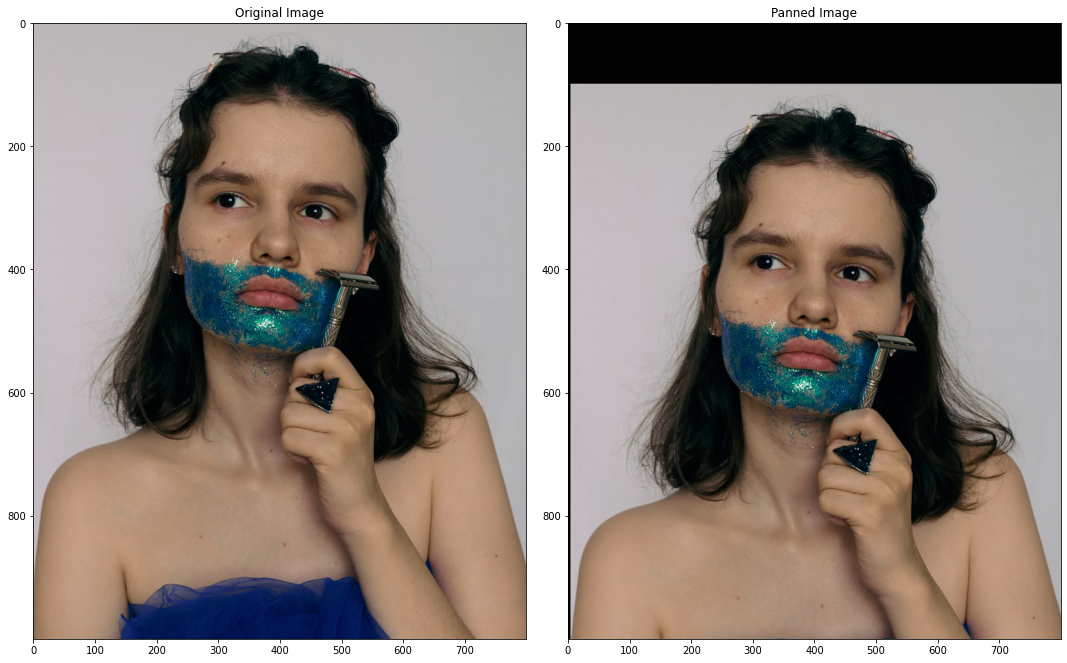

In [40]:
# display the pan augmentation 
image = image_paths[random.randint(0,1000)]# randomly selects an image with the index between 0 - 1000
original_image = mping.imread(image) # reads image path
panned_image = pan(original_image) # sends original image to function

fig, axs = plt.subplots(1, 2, figsize=(15,10)) # plot to display the images
fig.tight_layout() # tidy up the plot
axs[0].imshow(original_image) # original image
axs[0].set_title('Original Image')  # title of the original image
axs[1].imshow(panned_image) # displays the pan augmented image
axs[1].set_title('Panned Image') # titles the pan augmented image

In [41]:
# augmention for bightness
def img_random_brightness(image):
  brightness = iaa.Multiply((1.0,2.6)) # multiplys all pixels by a value
  image = brightness.augment_image(image) # augments the brightness of the image
  return image # returns an augmented image

Text(0.5, 1.0, 'Altered Image')

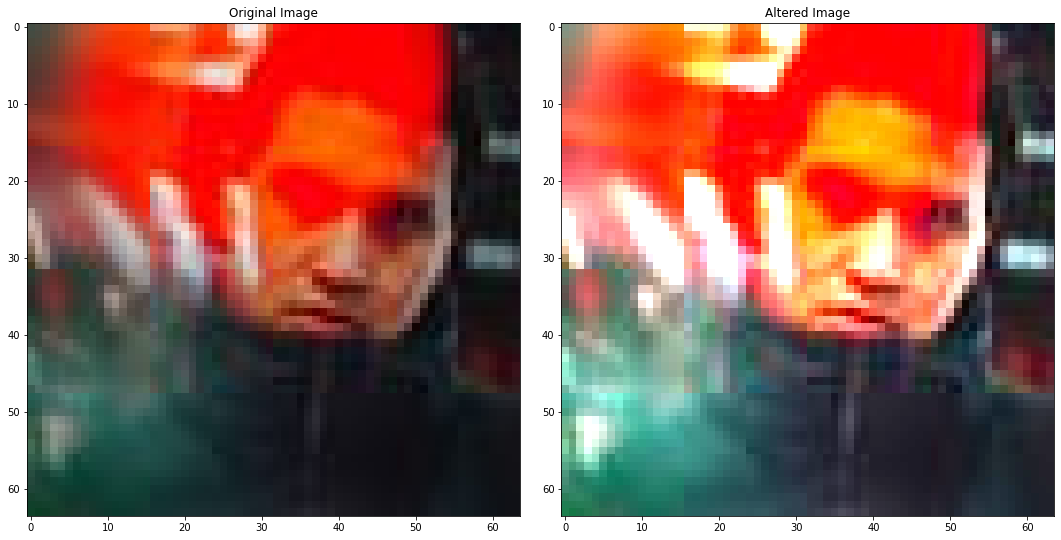

In [42]:
#display the brightness augmentation
image = image_paths[random.randint(0,1000)] # randomly selects an image with the index between 0 - 1000
original_image = mping.imread(image) # reads image path
brightness_altered_image = img_random_brightness(original_image) # sends original image to function

fig, axs = plt.subplots(1, 2, figsize=(15,10)) # plot to display the images
fig.tight_layout() # tidy up the plot
axs[0].imshow(original_image) # original image
axs[0].set_title('Original Image') # title of the original image
axs[1].imshow(brightness_altered_image) # displays the brightness augmented image
axs[1].set_title('Altered Image') # titles the augmented image

In [43]:
def img_gamma(image):
  gamma = iaa.GammaContrast((0.5, 1.5), per_channel=True)
  image = gamma.augment_image(image)
  return image


Text(0.5, 1.0, 'Altered Image')

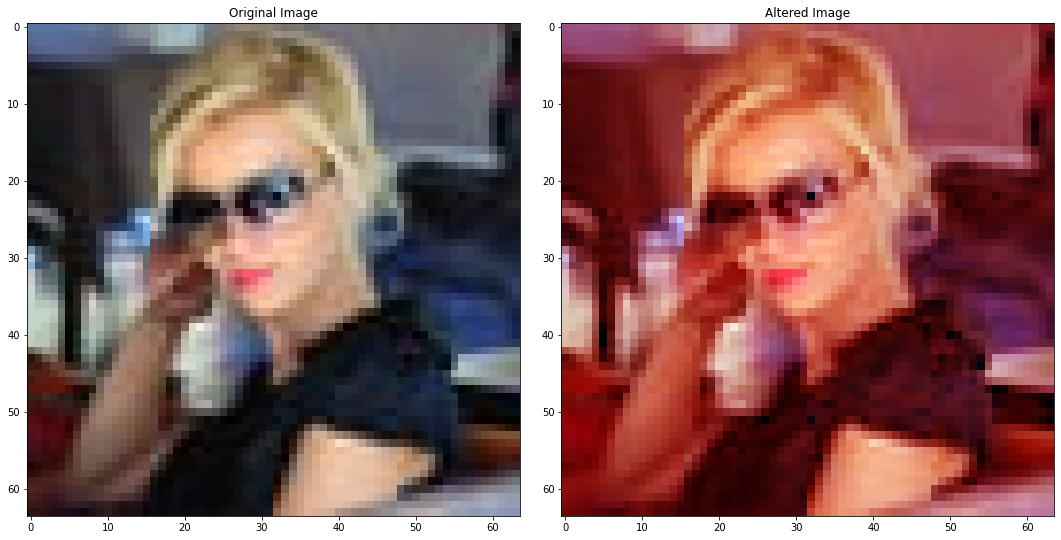

In [44]:
#display the brightness augmentation
image = image_paths[random.randint(0,1000)] # randomly selects an image with the index between 0 - 1000
original_image = mping.imread(image) # reads image path
gamma_altered_image = img_gamma(original_image) # sends original image to function

fig, axs = plt.subplots(1, 2, figsize=(15,10)) # plot to display the images
fig.tight_layout() # tidy up the plot
axs[0].imshow(original_image) # original image
axs[0].set_title('Original Image') # title of the original image
axs[1].imshow(gamma_altered_image) # displays the brightness augmented image
axs[1].set_title('Altered Image') # titles the augmented image

### function to call a random augmentation on an image

In [76]:
# randomise the occurance of the augmentations
def random_augment(image,annotation):
  image = mping.imread(image)
  if np.random.rand() < 0.0: # 50% chance image will be panned
    image = pan(image)
   # print("pan")
  if np.random.rand() < 0.0: # 50% chance image will be zoomed
    image = zoom(image)
   # print("Zoom")
  if np.random.rand() < 0.0: # 99% of iamges will be augmented
    image = img_random_brightness(image)
   # print("Brightness")
  if np.random.rand() < 0.0: # 50% of iamges will be augmented
    image = img_random_flip(image)
    #print("Flipped")
  if np.random.rand() < 0.50: # 70% chance of  gamma augment
    image = img_gamma(image)
  return image,annotation

### Check batch generator is working correctly

Text(0.5, 1.0, 'Validaiton Image')

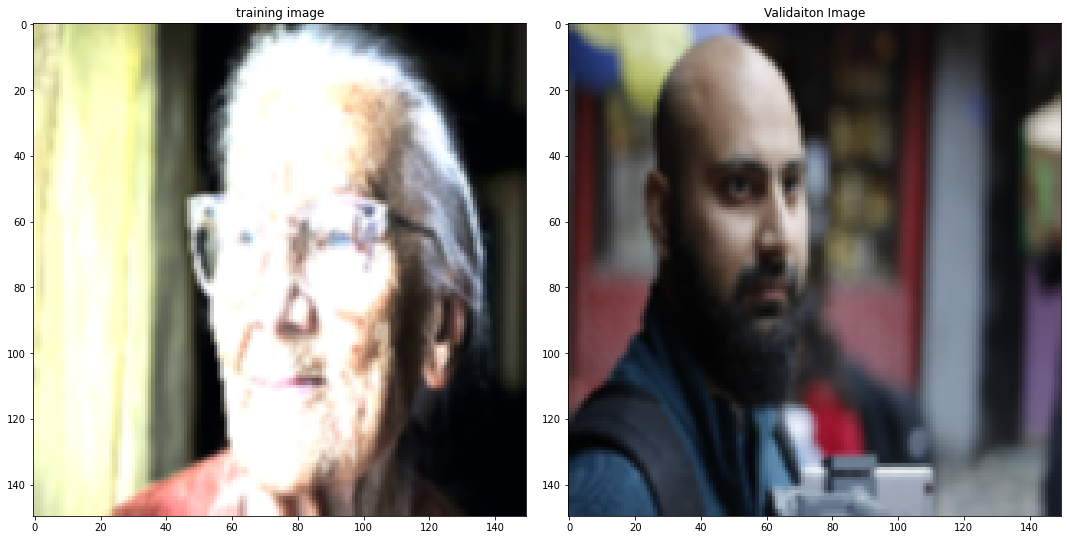

In [46]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))

fig, axs = plt.subplots(1, 2, figsize=(15,10)) # plot to display the images
fig.tight_layout() # tidy up the plot

axs[0].imshow(x_train_gen[0]) # original image
axs[0].set_title('training image') # title of the original image

axs[1].imshow(x_valid_gen[0]) # displays the brightness augmented image
axs[1].set_title('Validaiton Image') # titles the augmented image

# Model creation 

getting the class weights to try and balance the training from an inbalanced dataset

In [47]:
from sklearn.utils import class_weight
computed_class_weight_w = class_weight.compute_class_weight('balanced',np.unique((data['wrinkles'])),(data['wrinkles']))
print("wrinkles\n",computed_class_weight_w,"\n")
computed_class_weight_f = class_weight.compute_class_weight('balanced',np.unique((data['freakles'])),(data['freakles']))
print("freakles\n",computed_class_weight_f,"\n")
computed_class_weight_g = class_weight.compute_class_weight('balanced',np.unique((data['glasses'])),(data['glasses']))
print("glasses\n",computed_class_weight_g,"\n")
computed_class_weight_hc = class_weight.compute_class_weight('balanced',np.unique((data['hair_color'])),(data['hair_color']))
print("hair Colour\n",computed_class_weight_hc,"\n")
computed_class_weight_ht = class_weight.compute_class_weight('balanced',np.unique((data['hair_top'])),(data['hair_top']))
print("hair top\n",computed_class_weight_ht,"\n")

wrinkles
 [0.67071651 1.96441606] 

freakles
 [0.61374002 2.69799499] 

glasses
 [0.3971592  2.82545932 7.80072464] 

hair Colour
 [0.54741927 0.37204078 7.03594771 1.97704316 1.85443583 5.6957672
 2.49189815 9.2008547  0.38275556] 

hair top
 [5.32920792 0.75490884 0.51408787 1.84332192] 



In [48]:
class_weights = dict(enumerate((computed_class_weight_w,computed_class_weight_f,computed_class_weight_g,computed_class_weight_hc,computed_class_weight_ht)))
class_weights

{0: array([0.67071651, 1.96441606]),
 1: array([0.61374002, 2.69799499]),
 2: array([0.3971592 , 2.82545932, 7.80072464]),
 3: array([0.54741927, 0.37204078, 7.03594771, 1.97704316, 1.85443583,
        5.6957672 , 2.49189815, 9.2008547 , 0.38275556]),
 4: array([5.32920792, 0.75490884, 0.51408787, 1.84332192])}

In [119]:
first_layer = Input(shape = (150, 150, 3))

x = Conv2D(32, (3,3),  activation = ACTIVATION_LAYER, padding = "same")(first_layer)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)
x = Conv2D(32, (3,3), activation = ACTIVATION_LAYER, padding = "same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)

x = Conv2D(64, (3,3), activation = ACTIVATION_LAYER, padding = "same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)
x = Conv2D(64, (3,3), activation = ACTIVATION_LAYER, padding = "same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)

x = Conv2D(64, (3,3), activation = ACTIVATION_LAYER, padding = "same")(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3,3), activation = ACTIVATION_LAYER, padding = "same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)

x = Conv2D(64, (3,3), activation = ACTIVATION_LAYER, padding = "same")(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3,3), activation = ACTIVATION_LAYER, padding = "same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)

x = Conv2D(128, (3,3), activation = ACTIVATION_LAYER, padding = "same")(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3,3), activation = ACTIVATION_LAYER, padding = "same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)


x = Flatten()(x)

### Output layers, 5 in total for each class

In [120]:
 # for wrinkles prediction
w = Dense(1024, activation = ACTIVATION_LAYER)(x)
#w = Dropout(0.5)(w)
#w = Dense(64, activation = ACTIVATION_LAYER)(x)
wrinkles_output = Dense(units=2, activation=ACTIVATION_OUTPUT, name='wrinkles_output')(w)

In [121]:
# for freakles prediction
f = Dense(units=1024, activation='relu')(x)
#f = Dropout(0.5)(f)
#f = Dense(units=64, activation='relu')(f)
#f = Dropout(0.5)(f)
#f = Dense(units=64, activation='relu')(f)
freakles_output = Dense(units=2, activation=ACTIVATION_OUTPUT, name='freakles_output')(f)

In [122]:
# for glasses prediction
g = Dense(units=1024, activation='relu')(x)
#g = Dropout(0.5)(g)
#g = Dense(units=64, activation='relu')(g)
#g = Dropout(0.5)(g)
#g = Dense(units=64, activation='relu')(g)
glasses_output = Dense(units=3, activation=ACTIVATION_OUTPUT, name='glasses_output')(g)

In [123]:
# for hair colour prediction
hc= Dense(units=1024, activation='relu')(x)
hc = Dropout(0.5)(hc)
hc = Dense(units=512, activation='relu')(hc)
#hc = Dropout(0.5)(hc)
#hc = Dense(units=128, activation='relu')(hc)
#hc = Dropout(0.5)(hc)
#hc = Dense(units=128, activation='relu')(hc)
#hc = Dropout(0.5)(hc)
#hc = Dense(units=128, activation='relu')(hc)
#hc = Dropout(0.5)(hc)
#hc = Dense(units=64, activation='relu')(hc)
hair_colour_output = Dense(units=9, activation=ACTIVATION_OUTPUT, name='hair_colour_output')(hc)

In [124]:
# for hair top prediction
ht= Dense(units=1024, activation='relu')(x)
ht = Dropout(0.5)(ht)
ht = Dense(units=512, activation='relu')(ht)
#ht = Dropout(0.5)(ht)
#ht = Dense(units=128, activation='relu')(ht)
#ht = Dropout(0.5)(ht)
#ht = Dense(units=64, activation='relu')(ht)
hair_top_output = Dense(units=4, activation=ACTIVATION_OUTPUT, name='hair_top_output')(ht)

In [125]:
model = Model(first_layer, outputs=[wrinkles_output, freakles_output, glasses_output,hair_colour_output,hair_top_output])

# Compile Model

In [126]:
model.compile(optimizer=OPTIMIZER,
              loss={'wrinkles_output': 'categorical_crossentropy', 
                    'freakles_output': 'categorical_crossentropy', 
                    'glasses_output': 'categorical_crossentropy',
                    'hair_colour_output': 'categorical_crossentropy',
                    'hair_top_output': 'categorical_crossentropy'},
               metrics={'wrinkles_output': 'accuracy', 
                       'freakles_output': 'accuracy', 
                       'glasses_output': 'accuracy',
                       'hair_colour_output': 'accuracy',
                       'hair_top_output': 'accuracy'
                      })


In [127]:
from contextlib import redirect_stdout
if not os.path.exists('%s/Model_Data/%s/modelsummary.txt' %(root, MODEL_NAME)):
    with open('%s/Model_Data/%s/modelsummary.txt' %(root, MODEL_NAME), 'w') as f:
        with redirect_stdout(f):
            model.summary()
            print("Summary Written.")
else:
    print("Summary already saved.")
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_45 (Conv2D)              (None, 150, 150, 32) 896         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_45 (BatchNo (None, 150, 150, 32) 128         conv2d_45[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_30 (MaxPooling2D) (None, 75, 75, 32)   0           batch_normalization_45[0][0]     
____________________________________________________________________________________________

# Train model

In [128]:
history = model.fit(batch_generator(X_train, y_train, BATCH_SIZE, 1), # call to batch generator to get batches of images
                              steps_per_epoch=STEPS, # hyper parameter set at the start
                              epochs=EPOCS, # hyper parameter set at the start 
                              validation_data = batch_generator(X_valid,y_valid, 32, 0), # calls to batch generator for validation
                              validation_steps = 100, # number of steps for the validaiton of data
                              verbose = 1, # view training
                              class_weight = {
                                 'wrinkles_output':{0:class_weights[0][0],1:class_weights[0][1]},
                                  'freakles_output':{0:class_weights[1][0],1:class_weights[1][1]},
                                  'glasses_output':{0:class_weights[2][0],1:class_weights[2][1],2:class_weights[2][2]},
                                  'hair_colour_output':{0:class_weights[3][0],1:class_weights[3][1],2:class_weights[3][2],3:class_weights[3][3],
                                   4:class_weights[3][4],5:class_weights[3][5],6:class_weights[3][6],7:class_weights[3][7],8:class_weights[3][8]},
                                  'hair_top_output':{0:class_weights[4][0],1:class_weights[4][1],2:class_weights[4][2],3:class_weights[4][3]},
                               },)

Train for 50 steps, validate for 100 steps
Epoch 1/10
50/50 [==============================] - 58s 1s/step - loss: 6.0028 - wrinkles_output_loss: 0.7343 - freakles_output_loss: 0.7791 - glasses_output_loss: 1.1447 - hair_colour_output_loss: 1.9246 - hair_top_output_loss: 1.4201 - wrinkles_output_accuracy: 0.5644 - freakles_output_accuracy: 0.4944 - glasses_output_accuracy: 0.3663 - hair_colour_output_accuracy: 0.2013 - hair_top_output_accuracy: 0.2988 - val_loss: 5.6242 - val_wrinkles_output_loss: 0.7508 - val_freakles_output_loss: 0.7411 - val_glasses_output_loss: 0.9897 - val_hair_colour_output_loss: 1.7926 - val_hair_top_output_loss: 1.3500 - val_wrinkles_output_accuracy: 0.6888 - val_freakles_output_accuracy: 0.7034 - val_glasses_output_accuracy: 0.8656 - val_hair_colour_output_accuracy: 0.2525 - val_hair_top_output_accuracy: 0.5713
Epoch 2/10
50/50 [==============================] - 55s 1s/step - loss: 5.7109 - wrinkles_output_loss: 0.6951 - freakles_output_loss: 0.7148 - glasses_

# Check values of accuracy model has achived 

In [129]:
# plot history graphs from model training
def plot_history_graphs(data1, data2,title):
    plt.plot(history.history[data1], label = data1)
    plt.plot(history.history[data2], label = data2)
    plt.grid(True)
    plt.tight_layout()
    plt.title('Model %s'%title)
    plt.ylabel(data1)
    plt.xlabel("Epoch")
    plt.legend()
    if not os.path.exists("%s/Model_Data/%s/%s.png"% (root,MODEL_NAME,data1)):
        plt.savefig("%s/Model_Data/%s/%s.png"% (root,MODEL_NAME,data1))

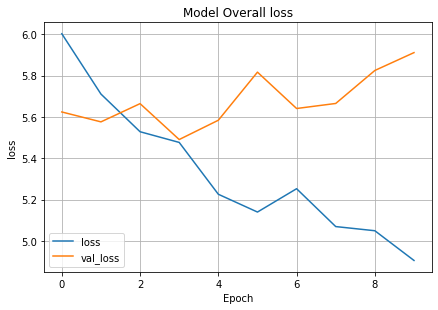

In [130]:
overall = plot_history_graphs('loss','val_loss','Overall loss')

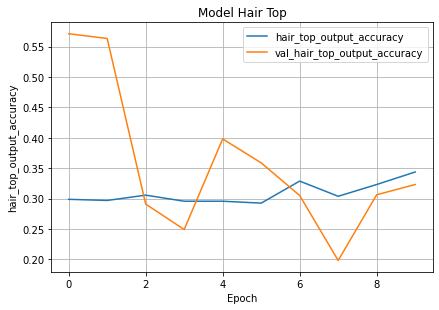

In [131]:
plot_history_graphs('hair_top_output_accuracy','val_hair_top_output_accuracy','Hair Top')

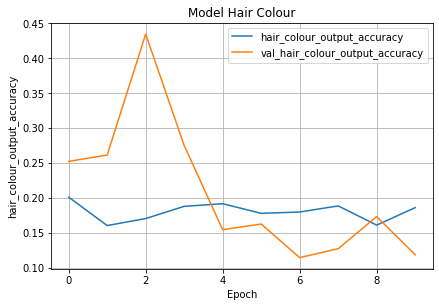

In [132]:
plot_history_graphs('hair_colour_output_accuracy','val_hair_colour_output_accuracy','Hair Colour')

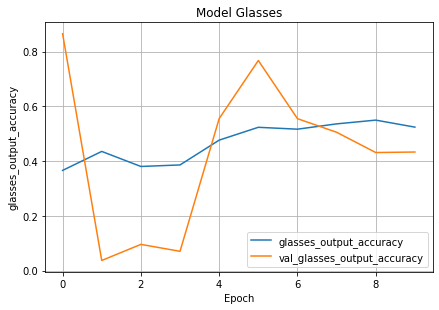

In [133]:
plot_history_graphs('glasses_output_accuracy','val_glasses_output_accuracy','Glasses')

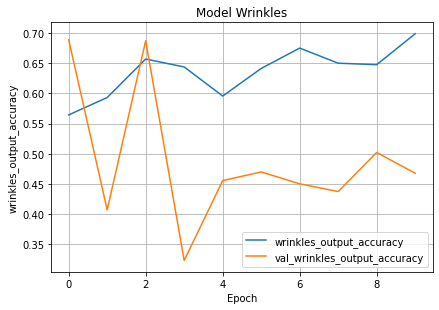

In [134]:
plot_history_graphs('wrinkles_output_accuracy','val_wrinkles_output_accuracy','Wrinkles')

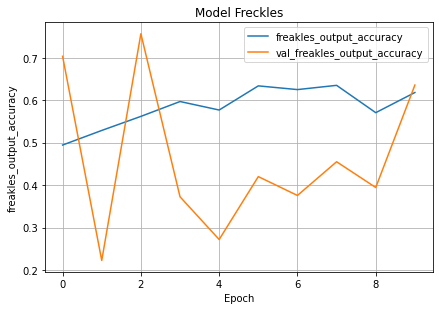

In [135]:
plot_history_graphs('freakles_output_accuracy','val_freakles_output_accuracy','Freckles')

# Save model

In [136]:
# save model weights
if not os.path.exists("%s/Model_Data/%s/%s.h5" % (root,MODEL_NAME,MODEL_NAME)):
        model.save("%s/Model_Data/%s/%s.h5" % (root,MODEL_NAME,MODEL_NAME))

# Model Evaluation

In [137]:
def evaluation_batch_generator(image_paths, annotations,COUNTS, batch_size = 128):
    batch_img = [] # stores image in list
    batch_annotations = [] # stores the annotation in a list 
    wrinkles,freakles,glasses,hair_colors,hair_tops = [], [],[],[],[]
    counts = 0
    for i in range(batch_size):
        if(counts < COUNTS):
            random_index = random.randint(0, len(image_paths) -1 ) # randomly selects image
            img = mping.imread(image_paths[random_index])
            person = data.iloc[random_index]
            wrinkle = person["wrinkles"]
            freakle = person["freakles"]
            glass = person["glasses"]
            hair_color = person["hair_color"]
            hair_top = person["hair_top"]
            annotation = annotations[random_index]
            wrinkles.append(to_categorical(wrinkle, len(dataset_dict['wrinkles_id'])))
            freakles.append(to_categorical(freakle, len(dataset_dict['freckles_id'])))
            glasses.append(to_categorical(glass, len(dataset_dict['glasses_id'])))
            hair_colors.append(to_categorical(hair_color, len(dataset_dict['hair_colour_id'])))
            hair_tops.append(to_categorical(hair_top, len(dataset_dict['hair_top_id'])))

            img = img_preprocess(img) # call to function
            batch_img.append(img) # appends the image to list
            batch_annotations.append(annotation) # appends the annotation angle to list
            counts+=1
            yield (np.asarray(batch_img), [np.array(wrinkles), np.array(freakles), np.array(glasses), np.array(hair_colors), np.array(hair_tops)]) # using yield to suspend the function
            wrinkles,freakles,glasses,hair_colors,hair_tops = [], [],[],[],[]

In [138]:
print(X_valid.shape,y_valid.shape)
score = model.evaluate(evaluation_batch_generator(X_valid, y_valid,12),verbose=1)

(431,) (431, 5)
     12/Unknown - 1s 75ms/step - loss: 5.5410 - wrinkles_output_loss: 0.6792 - freakles_output_loss: 0.5698 - glasses_output_loss: 0.9510 - hair_colour_output_loss: 2.0279 - hair_top_output_loss: 1.3131 - wrinkles_output_accuracy: 0.6026 - freakles_output_accuracy: 0.7179 - glasses_output_accuracy: 0.6026 - hair_colour_output_accuracy: 0.2051 - hair_top_output_accuracy: 0.3462

In [139]:
score_output = print('Losses\nTest loss: %s\nWrinkles loss: %s \nFreckles loss: %s \nGlasses loss: %s \nHair Color loss: %s \nHair Top loss: %s \n\nAccuracy\nWrinkles accuracy: %s \nFreckles accuracy: %s \nGlasses accuracy: %s \nHair Color accuracy: %s \nHair Top accuracy: %s \n' 
                     %(score[0], score[1],score[2], score[3],score[4], score[5],score[6], score[7],score[8], score[9],score[10]))



Losses
Test loss: 5.540980060895284
Wrinkles loss: 0.6791828 
Freckles loss: 0.5697809 
Glasses loss: 0.9509699 
Hair Color loss: 2.0279467 
Hair Top loss: 1.3130995 

Accuracy
Wrinkles accuracy: 0.6025641 
Freckles accuracy: 0.71794873 
Glasses accuracy: 0.6025641 
Hair Color accuracy: 0.20512821 
Hair Top accuracy: 0.34615386 



In [140]:
if not os.path.exists('%s/Model_Data/%s/evaluation_score.txt' %(root, MODEL_NAME)):
    with open('%s/Model_Data/%s/evaluation_score.txt' %(root, MODEL_NAME), 'w') as f:
        with redirect_stdout(f):
            print('Test loss: %s\nWrinkles loss: %s \nFreckles loss: %s \nGlasses loss: %s \nHair Color loss: %s \nHair Top loss: %s \nWrinkles accuracy: %s \nFreckles accuracy: %s \nGlasses accuracy: %s \nHair Color accuracy: %s \nHair Top accuracy: %s \n' 
                     %(score[0], score[1],score[2], score[3],score[4], score[5],score[6], score[7],score[8], score[9],score[10]))
    print("Score Written.")
else:
    print("Score Already present")
score_output

Score Written.


In [141]:
from google.colab import files


files.download("%s/Model_Data/%s/%s.h5" % (root,MODEL_NAME,MODEL_NAME))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>